In [4]:
import pandas as pd
import re
import os
import gzip

In [5]:
%matplotlib inline

In [6]:
pd.options.display.float_format = '{:,.4f}'.format

In [7]:
map_ = lambda f: lambda l: [f(x) for x in l]

In [13]:
def mkline(line):
    regex = re.compile('([a-zA-Z0-9_]*)-([0-9a-zA-Z]*)-(.*) (\d*) Thread-(\d*): (.*)')     
    headers = ["app", "commitid", "datefmt", "unix_tstamp", 'tid', 'message']    
    if not regex.match(line):
        print(line)
    return dict(zip(headers, regex.match(line).groups()))

def process_log_file(fname):
    def thunk():
        print("Processing: {}".format(fname))
        components = fname.split('/')
        run_name = components[-1]
        proc_file = '/Users/jrc12/josh/projects/processed_logs/{}'.format(run_name)
        if(os.path.exists(proc_file)):
            print("Using cached file: {}".format(proc_file))
            return pd.read_csv(proc_file)
        content = open('/Users/jrc12/josh/projects/logs/{}'.format(run_name)).read()
        log_lines = pd.DataFrame(map_(mkline)(content.splitlines()))    
        log_lines.to_csv('/Users/jrc12/josh/projects/processed_logs/{}'.format(run_name), index=False)
        return log_lines
    return thunk

In [20]:
"""
 - Snapshot completion time (nanoseconds)
 - Update time
 - ratio of collects to snapshot attempts
 - time to collect
 - % of times when the initial double collect succeeds
 - % of times when a snapshot ends with generating a new one
 - % of times when a snapshot ends with using an old one
"""
# Memory usage would also be useful here
statistics = ['Snap Time', 'Collect Count', 'Collects per Snap Count', 'Collect Time', 'Case A (==1) Count',
              'Case A (>=2) Count', 'Case B Count', 'Total Execution Time']
trial_params = ['Num Procs', 'Snap Count']
columns = trial_params + statistics
def to_snap_time_(proc_snaps):
    vals = proc_snaps.sort_values(by='unix_tstamp')[['unix_tstamp', 'tid']].values
    return pd.Series(map_(lambda args: (int(args[1][0]) - int(args[0][0])))(zip(vals[::2], vals[1:][::2])))


def to_data_point(id_, frame_thunk):
    cache_dir = '/Users/jrc12/josh/projects/processed_logs/to_data_point_cache'
    cache_file = os.path.join(cache_dir, id_)
    if os.path.exists(cache_file):
        print("`to_data_point` using data cache: {}".format(id_))
        out_series = pd.Series.from_csv(cache_file)
        if 'Snap Count Normalized' not in out_series:
            out_series['Snap Count Normalized'] = out_series['Snap Count']/out_series['Num Procs']
        return out_series
    frame = frame_thunk()
    time_elapsed_stat = lambda f: frame[f].groupby('tid').apply(to_snap_time_)
    num_procs = len(set(frame.tid.values))
    snap_count = len(frame[frame.message == 'START SNAP'])
    total_execution_time = frame.unix_tstamp.map(int).max() - frame.unix_tstamp.map(int).min()
    case_a_count = len(frame[frame.message.str.match('CASE A')])
    case_a1_count = len(frame[frame.message == 'CASE A - 1'])
    case_an_count = case_a_count - case_a1_count
    case_b = snap_count - case_a_count
    collect_count = len(frame[frame.message == 'COLLECT BEGIN'])
    proc_grouped = frame.groupby('tid')
    snap_filter = frame.message.str.match('.*SNAP.*')
    assert(len(set(frame[snap_filter].message)) == 2)
    snap_time = time_elapsed_stat(snap_filter).median().mean()
    collect_filter = frame.message.str.match('.*COLLECT.*')
    assert(len(set(frame[snap_filter].message)) == 2)
    collect_time = time_elapsed_stat(collect_filter).median()
    
    out_series = pd.Series([num_procs, snap_count, snap_time, collect_count, float(collect_count)/snap_count, collect_time, case_a1_count, case_an_count, case_b, total_execution_time], columns)
    out_series['Snap Count Normalized'] = out_series['Snap Count']/out_series['Num Procs']
    out_series.to_csv(cache_file)

    return out_series

In [150]:
log_root = '/Users/jrc12/josh/projects/logs/'
series_list = []

for f in os.listdir(log_root):
    if '.tmp.' in f:
        continue
    series_list.append(to_data_point(f, process_log_file(os.path.join(log_root, f))))
frame = pd.DataFrame(series_list)

`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_18-55-00_UTC_2018.log


/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_18-55-01_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_18-55-02_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_18-55-05_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_18-55-10_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_18-55-19_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_18-55-20_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_18-55-22_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_18-55-26_UTC_2018.log
`to_data_point` 

`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_21-16-45_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_21-16-48_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_21-16-51_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_21-16-54_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_21-16-58_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_21-17-01_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_21-17-06_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Mon_Oct_22_21-17-10_UTC_2018.log
`to_data_point` 

`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Tue_Oct_23_09-00-31_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Tue_Oct_23_09-00-48_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Tue_Oct_23_09-37-23_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Tue_Oct_23_09-37-34_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Tue_Oct_23_09-37-48_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Tue_Oct_23_09-38-23_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Tue_Oct_23_10-08-34_UTC_2018.log
`to_data_point` using data cache: unbounded_regs-abb7053b043010ba1c9a631c69f622278d57e539-Tue_Oct_23_10-08-38_UTC_2018.log
`to_data_point` 

In [151]:
set(frame[frame['Num Procs'] == 32]['Snap Count Normalized'].values)

{201.0, 301.0, 501.0, 901.0, 1701.0, 3301.0, 6501.0}

In [152]:
frame

,Num Procs,Snap Count,Snap Time,Collect Count,Collects per Snap Count,Collect Time,Case A (==1) Count,Case A (>=2) Count,Case B Count,Total Execution Time,Snap Count Normalized
0,8.0000,"2,408.0000",108.0432,"5,079.0000",2.1092,4.0000,"2,161.0000",183.0000,64.0000,"358,987.0000",301.0000
1,8.0000,"7,208.0000",120.2525,"15,451.0000",2.1436,3.0000,"6,268.0000",749.0000,191.0000,"977,575.0000",901.0000
2,8.0000,"13,608.0000",88.1725,"28,562.0000",2.0989,4.0000,"12,316.0000",989.0000,303.0000,"2,537,901.0000","1,701.0000"
3,8.0000,"26,408.0000",79.2733,"54,904.0000",2.0791,4.0000,"24,405.0000","1,485.0000",518.0000,"5,327,544.0000","3,301.0000"
4,8.0000,"52,008.0000",104.4882,"110,742.0000",2.1293,4.0000,"45,564.0000","4,970.0000","1,474.0000","8,521,990.0000","6,501.0000"
5,16.0000,"4,816.0000",91.7757,"10,482.0000",2.1765,5.0000,"4,085.0000",522.0000,209.0000,"635,983.0000",301.0000
6,16.0000,"8,016.0000",72.3862,"17,045.0000",2.1264,7.0000,"7,100.0000",608.0000,308.0000,"1,492,509.0000",501.0000
7,16.0000,"14,416.0000",137.8269,"30,314.0000",2.1028,9.0000,"13,103.0000",829.0000,484.0000,"3,996,198.0000",901.0000
8,16.0000,"27,216.0000",89.2014,"59,522.0000",2.1870,5.0000,"22,641.0000","2,828.0000","1,747.0000","3,797,299.0000","1,701.0000"
9,16.0000,"52,816.0000",106.1852,"115,042.0000",2.1782,8.0000,"44,544.0000","5,039.0000","3,233.0000","11,725,950.0000","3,301.0000"


In [153]:
interestingSnapCounts = list(set(frame[frame['Num Procs'] == 64]['Snap Count Normalized'].values))
interestingSnapCounts

[1701.0, 901.0, 201.0, 301.0, 501.0]

In [154]:
interestingSnapCounts = [201, 301, 501, 901]

In [155]:
plottableSeries = lambda frame: lambda ix: lambda field: frame.set_index(['Snap Count Normalized', 'Num Procs']).loc[ix].sort_index()[field]
graph = lambda field: lambda snap_counts: lambda xaxis: pd.DataFrame({ count:plottableSeries(frame[xaxis])(count)(field).groupby('Num Procs').median() for count in snap_counts})

In [168]:
frame.columns

Index(['Num Procs', 'Snap Count', 'Snap Time', 'Collect Count',
       'Collects per Snap Count', 'Collect Time', 'Case A (==1) Count',
       'Case A (>=2) Count', 'Case B Count', 'Total Execution Time',
       'Snap Count Normalized'],
      dtype='object')

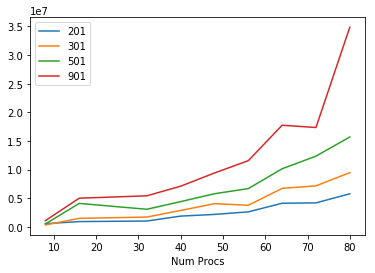

In [165]:
graph('Total Execution Time')(interestingSnapCounts)(frame['Num Procs'] < 100).plot()

(0.09976515488179172, 0.10843757130002918)

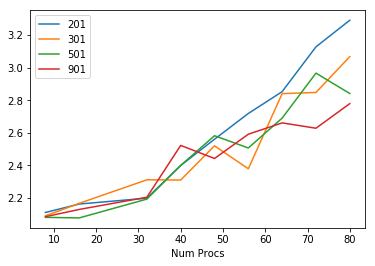

In [193]:
g = graph('Collects per Snap Count')(interestingSnapCounts)(frame['Num Procs'] < 100)
g.plot()
p = g.median(axis = 1)
delta = p - p.shift(1)
delta.median(), delta.mean()

Num Procs
8.0000         nan
16.0000     7.5000
32.0000    -0.5000
40.0000     4.5000
48.0000     3.2500
56.0000    -0.7500
64.0000    21.0000
72.0000    38.5000
80.0000   104.0000
dtype: float64

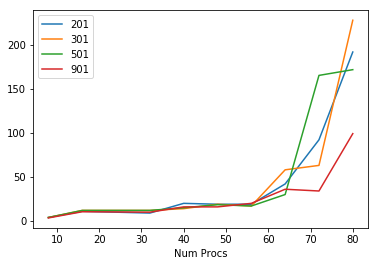

In [194]:
g = graph('Collect Time')(interestingSnapCounts)(frame['Num Procs'] < 100)
g.plot()
p = g.median(axis = 1)
delta = p - p.shift(1)
delta

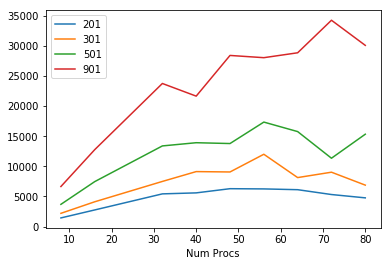

In [196]:
g = graph('Case A (==1) Count')(interestingSnapCounts)(frame['Num Procs'] < 100)
g.plot()

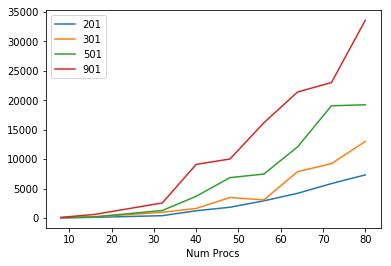

In [197]:
g = graph('Case B Count')(interestingSnapCounts)(frame['Num Procs'] < 100)
g.plot()